In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import numpy as np
import datetime
import gc

In [4]:
# sns.set(style="white")
plt.style.use("dark_background")

In [5]:
from utils import sql_table_to_pandas, str2iter_match_ratio
from plotting import (
    plot_countplot,
    plot_aggregated_barplot,
    plot_lineplot,
    plot_normalised_barplot,
    plot_distplot
)

In [6]:
pd.set_option(
    'display.max_rows', 100,
    'display.max_columns', None,
    'display.max_colwidth', 200,
    'display.width', 100,
    'display.float_format', '{:4,.2f}'.format
)


## Dataset description

- *status*: investigation status
- *time*: the time of accident
- *day*: the day of accident
- *month*: the monthe of accident
- *year*: the year of accdient
- *first_flight*: the year of aircraft first flight
- *total_airframe_hrs*: the hours that aircraft flied
- *aircraft_type*: the model of aircraft
- *operator*: the company, organisation or individual operating the aircraft at the time of the accident
- *country*: the country of accident
- *location*: more detailed location of accident
- *phase*: the phase of flight
- *nature*: the nature of the flight
- *engines*: number and type (model and mark) of engines
- *narrative*: the description of the occurrence
- *probable_cause*: the probable cause of the accident as established by the accident investigators
- *aircraft_damage*: describes the amount of damage to the airplane as a result of the occurrence
- *departure_airport*: the last airport of departure before the accident
- *destination_airport*: the scheduled destination airport
- *crew_occupants*: the exact number of flight- and cabincrew members aboard the aircraft at the time of departure
- *crew_fatalities*: the number of crew members who fatally injured as a direct result of the accident
- *passengers_occupants*: the number of passengers aboard the aircraft at the time of departure
- *passengers_fatalities*: the number of passengers who fatally injured as a direct result of the accident
- *total_occupants*: crew_occupants + passengers_occupants
- *total_fatalities*: crew_fatalities + passengers_fatalities

## Dataset cleaning

In [7]:
df = sql_table_to_pandas('../db_config.JSON', 'accidents')

In [8]:
# df_aircraft = sql_table_to_pandas('../db_config.JSON', 'aircraft')
# df_aircraft.columns = [c if 'aircraft' in c else f'aircraft_{c}' for c in df_aircraft.columns]
# df = pd.merge(df_accidents, df_aircraft, how='left', on='aircraft_type')

In [9]:
df = df[(df['year'] > 1919) & (df['year'] < 2020)] # selecting only full years

In [10]:
df = df.replace({None: np.nan, 'None': np.nan})

###### time

In [11]:
def correct_time(x) -> datetime.time or np.nan:
    """Removes times which are not in local time of accident."""
    if pd.isnull(x):
        return np.nan
    
    # ca or c. means circa which translated from latin means approximate
    x = x.replace('ca', '').replace('c.', '').replace(' ', '')
    

    if re.match(r'^(2[0-3]|[01]?[0-9]):([0-5]?[0-9])$', x):
        return datetime.datetime.strptime(x, '%H:%M').time()
    elif re.match(r'^(2[0-3]|[01]?[0-9]):([0-5]?[0-9]):([0-5]?[0-9])$', x):
        return datetime.datetime.strptime(x, '%H:%M:%S').time()
    else:
        return np.nan


def get_time_range(x) -> str or np.nan:
    if pd.isnull(x):
        return np.nan

    if x < datetime.time(4, 0):
        return '00:00 - 03:59'
    elif x < datetime.time(8, 0):
        return '04:00 - 07:59'
    elif x < datetime.time(12, 0):
        return '08:00 - 11:59'
    elif x < datetime.time(16, 0):
        return '12:00 - 15:59'
    elif x < datetime.time(20, 0):
        return '16:00 - 19:59'
    else:
        return '20:00 - 23:59'

In [12]:
df['time'] = df['time'].apply(lambda x: np.nan if pd.isnull(x) else str(x)[-8:])
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time

In [13]:
df['time_range'] = df['time'].apply(get_time_range)
# df.drop(columns=['time'], inplace=True)

In [15]:
df['time_range'].value_counts()

12:00 - 15:59    1902
08:00 - 11:59    1867
16:00 - 19:59    1726
20:00 - 23:59    1099
04:00 - 07:59     877
00:00 - 03:59     564
Name: time_range, dtype: int64

###### weekday

No correction

In [175]:
df['weekday'].value_counts()

Friday       3511
Thursday     3356
Wednesday    3299
Tuesday      3298
Monday       3150
Saturday     3029
Sunday       2606
Name: weekday, dtype: int64

###### day

No correction

In [176]:
df['day'].value_counts()

10.00    889
24.00    791
15.00    778
27.00    769
19.00    763
23.00    753
6.00     750
13.00    745
17.00    742
18.00    742
11.00    738
12.00    738
22.00    736
4.00     735
9.00     735
28.00    732
14.00    728
7.00     722
26.00    719
21.00    708
25.00    707
16.00    705
2.00     703
8.00     697
5.00     683
3.00     678
30.00    676
20.00    671
1.00     662
29.00    654
31.00    400
Name: day, dtype: int64

###### month

No correction

In [177]:
df['month'].value_counts()

12.00    2013
1.00     2005
3.00     2001
9.00     1988
5.00     1956
7.00     1884
6.00     1833
8.00     1833
11.00    1828
4.00     1789
10.00    1746
2.00     1639
Name: month, dtype: int64

###### year

In [178]:
df['year'].iloc[:10]

0     1969
3     1971
4     1961
5     1961
6     1961
7     1961
8     1961
9     1961
10    1961
11    1961
Name: year, dtype: int64

In [179]:
df['decade'] = (df['year'] // 10 * 10).apply(lambda x: f'{x}s')

In [180]:
df['decade'].value_counts()

1940s    5694
1970s    2793
1960s    2546
1990s    2518
1950s    2330
1980s    2280
2000s    2170
2010s    1979
1930s     376
1920s      73
Name: decade, dtype: int64

###### first_flight

In [181]:
def get_age_range(age) -> str or np.nan:
    if pd.isnull(age):
        return np.nan
    
    if age < 1:
        return '0 - 1'
    elif age < 3:
        return '1 - 3'
    elif age < 5:
        return '3 - 5'
    elif age < 10:
        return '5 - 10'
    elif age < 20:
        return '10 - 20'
    elif age < 30:
        return '20 - 30'
    elif age < 50:
        return '30 - 50'
    else:
        return '> 50'

In [182]:
df['aircraft_age'] = (df['year'] - df['first_flight']).apply(lambda x: np.nan if x < 0 or np.isnan(x) else x)
df['aircraft_age_range'] = df['aircraft_age'].apply(get_age_range)
df.drop(columns=['first_flight'], inplace=True)

In [183]:
df['aircraft_age_range'].value_counts()

10 - 20    3781
1 - 3      3233
5 - 10     2778
20 - 30    2627
30 - 50    1824
0 - 1      1480
3 - 5      1373
> 50        223
Name: aircraft_age_range, dtype: int64

###### total_airframe_hrs

In [184]:
df['total_airframe_hrs'] = df['total_airframe_hrs'].apply(lambda x: x if isinstance(x, float) else np.nan)

###### aircraft_damage

In [185]:
df['aircraft_damage'].replace({'Missing': 'Unknown'}, inplace = True)

###### phase

In [186]:
df['phase'].replace({'()': 'Unknown', '(CMB)': 'Unknown'}, inplace = True)

In [187]:
df['phase'].value_counts()

En route (ENR)             5490
Unknown (UNK)              4823
Landing (LDG)              4350
Approach (APR)             2568
Takeoff (TOF)              1981
Standing (STD)             1595
Initial climb (ICL)        1077
Taxi (TXI)                  431
Maneuvering (MNV)           363
Pushback / towing (PBT)      66
Unknown                      15
Name: phase, dtype: int64

###### country

In [188]:
df['country'].replace({'Unknown country': 'Unknown', '': 'Unknown'}, inplace = True)

In [189]:
df['country'].value_counts()

United States of America    4084
Russia                      1257
Unknown                      854
United Kingdom               820
Canada                       779
                            ... 
Mauritius                      1
French Guiana                  1
Tuvalu                         1
Monaco                         1
Tonga                          1
Name: country, Length: 231, dtype: int64

###### nature

In [190]:
def get_nature_group(x) -> str:
    if x in ('Military', 'Unknown', 'Test', 'Cargo', 'Private', 'Official state flight', ):
        return x
    elif x in ('Executive', 'Training', ):
        return 'Training / Executive'
    elif 'Passenger' in x:
        return 'Passenger'
    elif x in ('Agricultural',  'Survey/research', 'Aerial Work (Calibration, Photo)'):
        return 'Scientific'
    else:
        return 'Other'

In [191]:
df['nature_group'] = df['nature'].apply(get_nature_group)

In [192]:
df['nature_group'].value_counts()

Military                 8155
Passenger                6760
Unknown                  3052
Cargo                    1997
Other                    1148
Training / Executive      886
Scientific                296
Test                      227
Private                   198
Official state flight      40
Name: nature_group, dtype: int64

In [261]:
df.head()

,status,time,weekday,day,month,year,first_flight,total_airframe_hrs,aircraft_type,operator,country,location,phase,nature,engines,narrative,probable_cause,aircraft_damage,departure_airport,destination_airport,crew_occupants,crew_fatalities,passengers_occupants,passengers_fatalities,total_occupants,total_fatalities,id,time_range
0,,NaN,Wednesday,1.00,1.00,1969,"1,966.00",nan,Lockheed C-130E Hercules,Royal Saudi Air Force - RSAF,France,Paris-Le Bourget Airport (LBG),Landing (LDG),Military,NaN,Crashed and burned some 200 yards short of the runway.,NaN,Damaged beyond repair,?,"Paris-Le Bourget Airport (LBG/LFPB) , France",6.00,6.00,0.00,0.00,6.00,6.00,1,NaN
3,,NaN,NaN,nan,nan,1971,"1,958.00",nan,Lockheed L-1049H Super Constellation,Unum Inc.,United States of America,"Kingman Airport, AZ (IGM)",Standing (STD),Unknown,NaN,"Wing exploded on ground. Fuselage used as gate guard, until being broken up in 1977.",NaN,Damaged beyond repair,?,?,0.00,nan,0.00,nan,0.00,nan,4,NaN
4,,NaN,NaN,nan,nan,1961,"1,954.00",nan,Bristol 170 Freighter 31M,Pakistan Air Force,Unknown country,at an unknown location,Unknown (UNK),Military,2 Bristol Hercules 734,Reportedly crashed.,NaN,Damaged beyond repair,?,?,nan,nan,nan,nan,nan,nan,5,NaN
5,,17:58,Sunday,31.00,12.00,1961,"1,961.00",593.00,Ilyushin Il-18V,Aeroflot / Armenia,Russia,3 km (1.9 mls) SW Mineralnye Vody Airport (MRV),Initial climb (ICL),Domestic Non Scheduled Passenger,4 Ivchenko AI-20,"An Ilyushin 18V passenger plane was damaged beyond repair in an accident near Mineralnye Vody Airport (MRV), Russia. There were 110 passengers on board and nine crew members. Thirty passengers and...",NaN,Damaged beyond repair,"Tbilisi Airport (TBS/UGGG) , Georgia","Mineralnye Vody Airport (MRV/URMM) , Russia",2.00,9.00,30.00,110.00,32.00,119.00,6,16:00 - 19:59
6,,NaN,Friday,29.00,12.00,1961,"1,944.00",nan,Douglas C-47A-10-DK (DC-3),Garuda Indonesia Airways,Indonesia,near Surabaya,Unknown (UNK),Unknown,2 Pratt & Whitney R-1830-92,Crashed.,NaN,Damaged beyond repair,?,?,nan,nan,nan,nan,nan,nan,7,NaN


## Data Analysis

### Timely Analysis

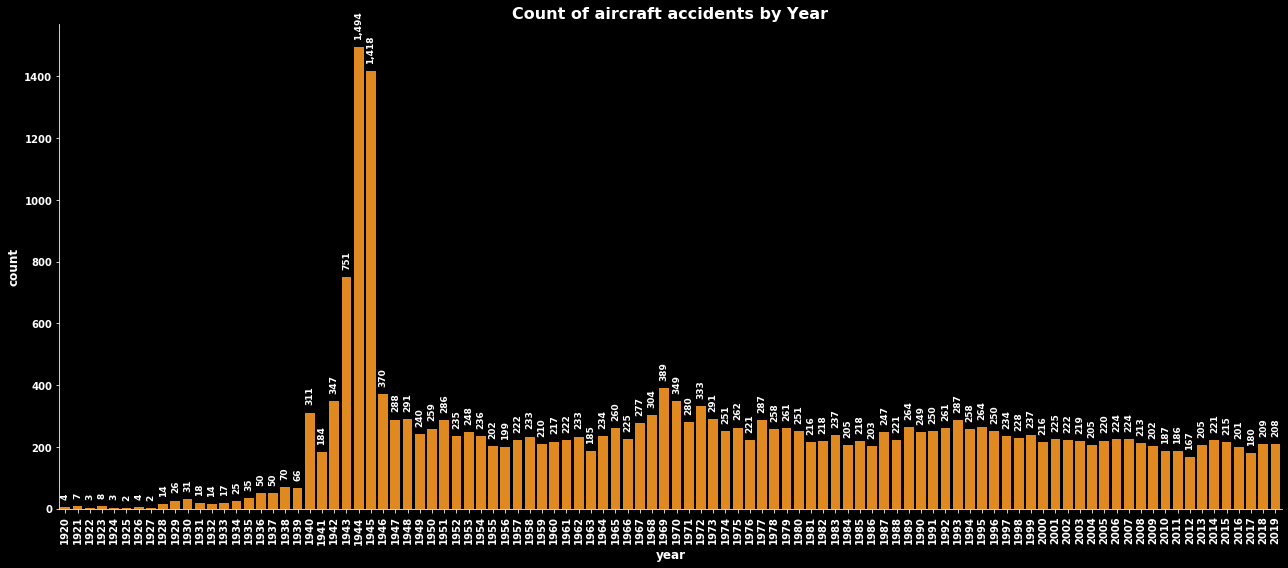

In [193]:
plot_countplot(
    df, 
    'year', 
    hue_column=None, 
    figsize=(18, 8), 
    title='Count of aircraft accidents by Year'
)

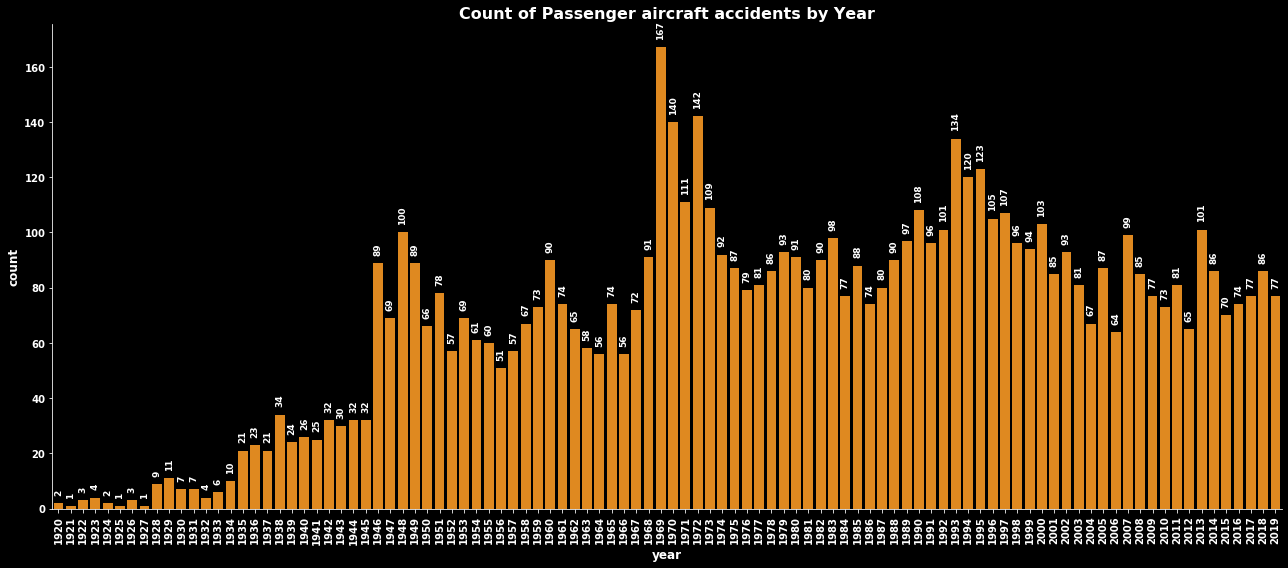

In [194]:
plot_countplot(
    df[df['nature_group'] == 'Passenger'], 
    'year', 
    figsize=(18, 8), 
    title='Count of Passenger aircraft accidents by Year'
)

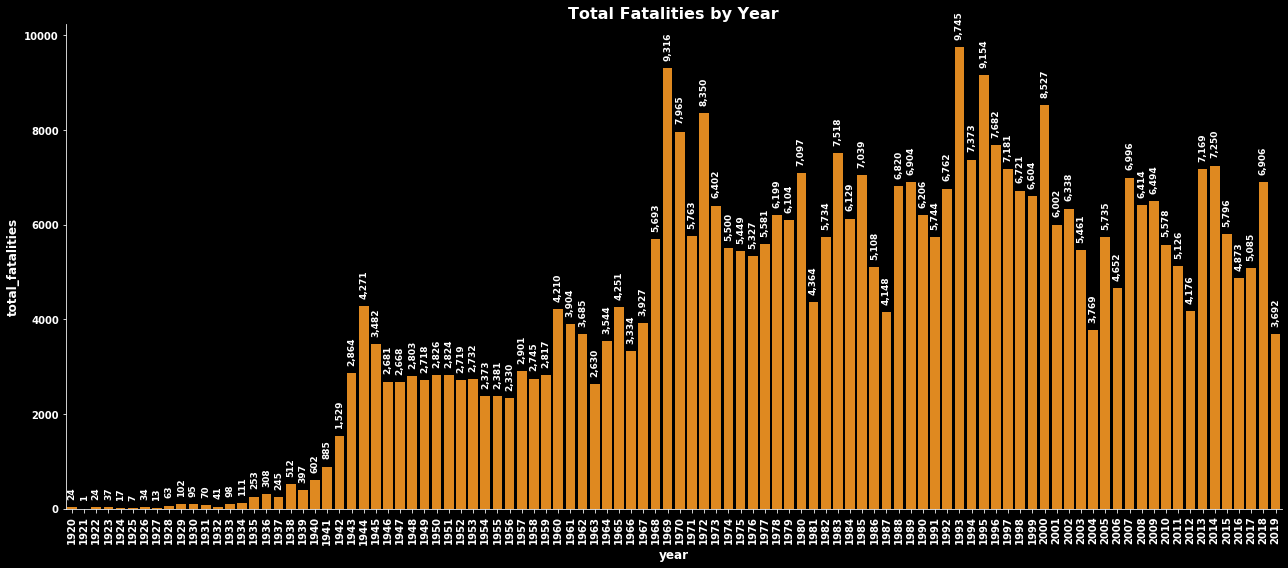

In [195]:
plot_aggregated_barplot(
    df,
    'year',
    'total_fatalities',
    'sum',
    figsize=(18, 8),
    title='Total Fatalities by Year'
)

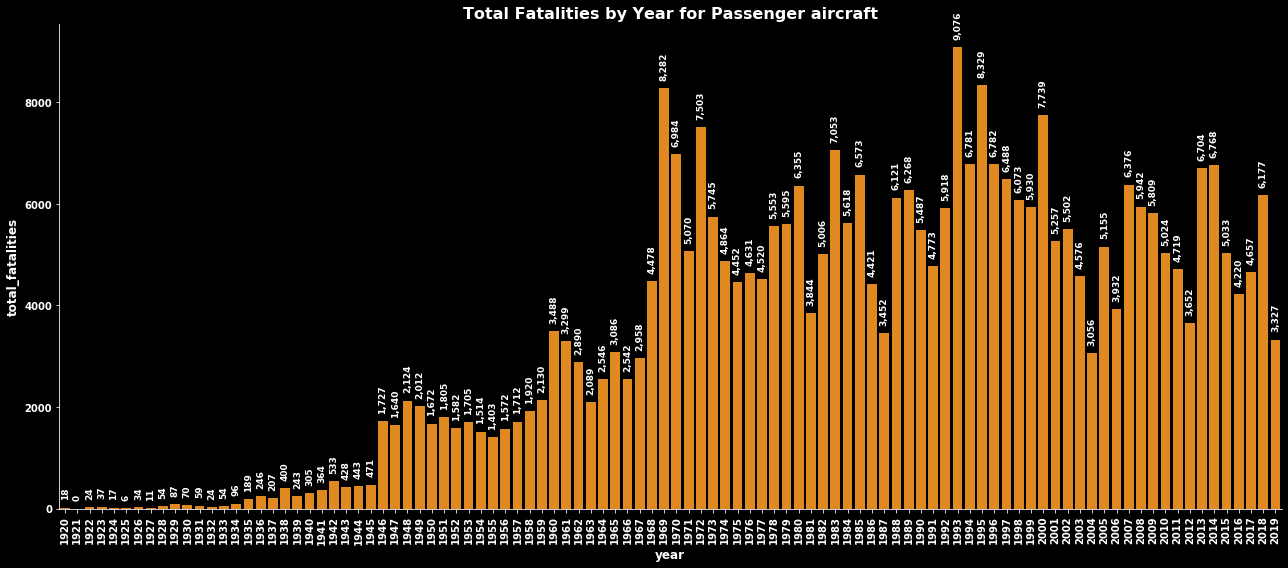

In [196]:
plot_aggregated_barplot(
    df[df['nature_group'] == 'Passenger'],
    'year',
    'total_fatalities',
    'sum',
    figsize=(18, 8),
    title='Total Fatalities by Year for Passenger aircraft'
)

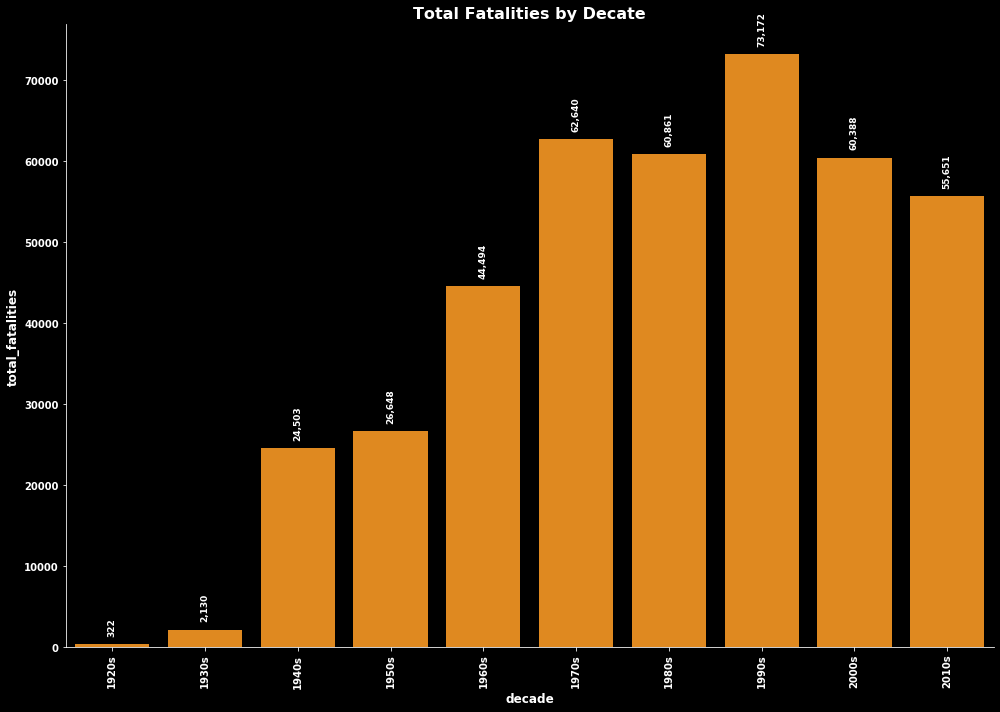

In [197]:
plot_aggregated_barplot(
    df,
    'decade',
    'total_fatalities',
    'sum',
    figsize=(14, 10),
    title='Total Fatalities by Decate'
)

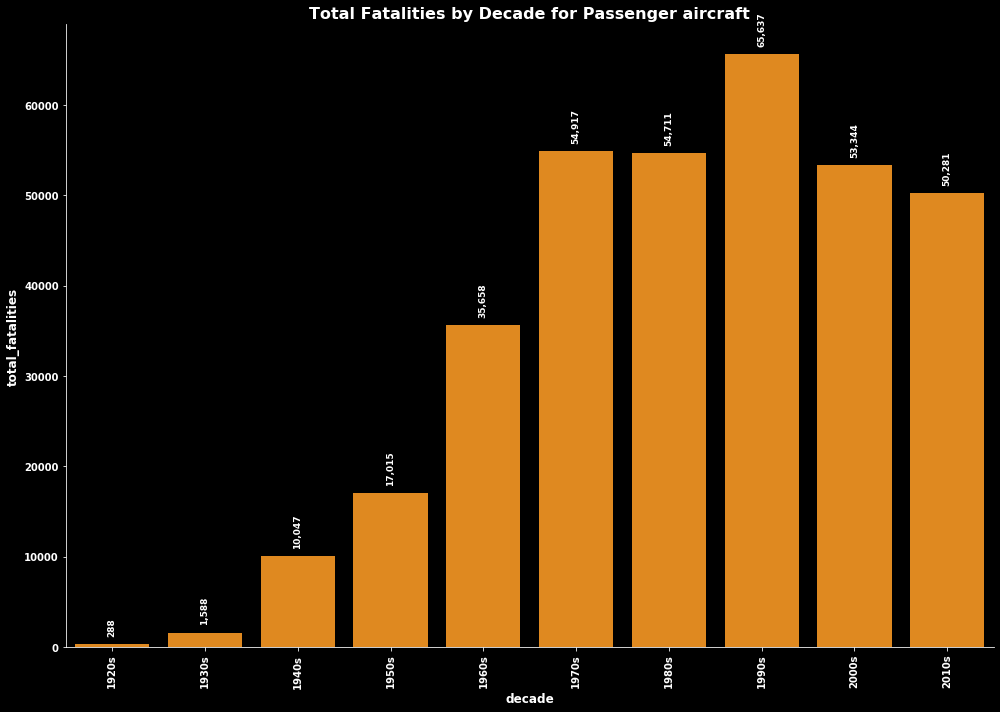

In [198]:
plot_aggregated_barplot(
    df[df['nature_group'] == 'Passenger'],
    'decade',
    'total_fatalities',
    'sum',
    figsize=(14, 10),
    title='Total Fatalities by Decade for Passenger aircraft'
)

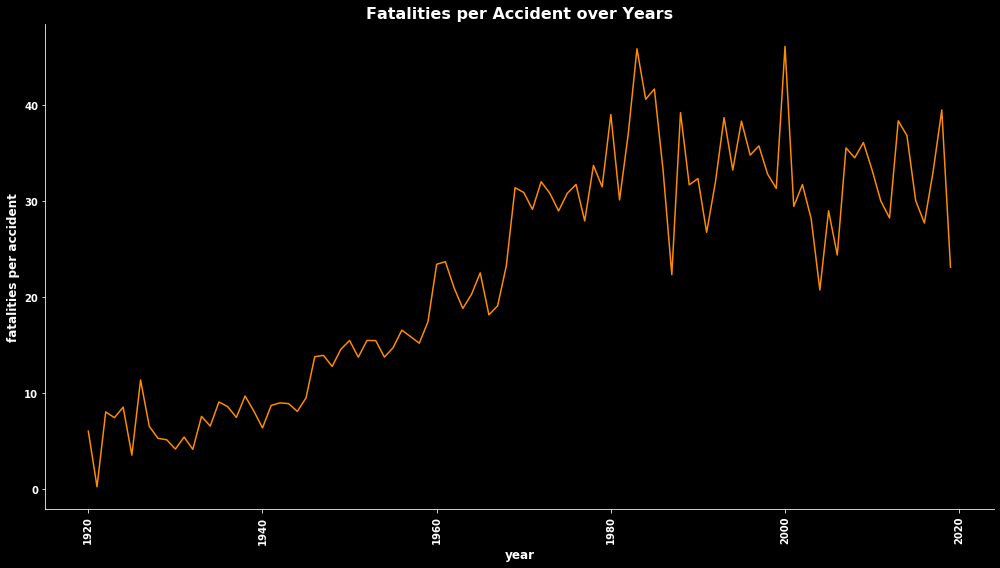

In [239]:
temp = df[pd.notna(df['total_fatalities'])].groupby('year').agg({'total_fatalities': ('sum', 'count')})
temp.columns = ['_'.join(col).strip() for col in temp.columns]
temp = temp.reset_index()
temp['fatalities per accident'] = temp['total_fatalities_sum'] / temp['total_fatalities_count']
plot_lineplot(
    temp,
    'year',
    'fatalities per accident',
    title='Fatalities per Accident over Years'

)

In [241]:
temp = df[pd.notna(df['total_fatalities'])].groupby('year').agg({'total_fatalities': 'sum', 'total_occupants': 'sum'})
# temp.columns = ['_'.join(col).strip() for col in temp.columns]
# temp = temp.reset_index()
# temp['fatalities per accident'] = temp['total_fatalities_sum'] / temp['total_fatalities_count']
# plot_lineplot(
#     temp,
#     'year',
#     'fatalities per accident',
#     title='Fatalities per Accident over Years'

# )

In [242]:
temp

,total_fatalities,total_occupants
year,,
1920,24.00,20.00
1921,1.00,1.00
1922,24.00,24.00
1923,37.00,20.00
1924,17.00,17.00
1925,7.00,4.00
1926,34.00,23.00
1927,13.00,3.00
1928,63.00,60.00


In [243]:
df.head()

,status,weekday,day,month,year,total_airframe_hrs,aircraft_type,operator,country,location,phase,nature,engines,narrative,probable_cause,aircraft_damage,departure_airport,destination_airport,crew_occupants,crew_fatalities,passengers_occupants,passengers_fatalities,total_occupants,total_fatalities,id,time_range,decade,aircraft_age,aircraft_age_range,nature_group
0,,Wednesday,1.00,1.00,1969,nan,Lockheed C-130E Hercules,Royal Saudi Air Force - RSAF,France,Paris-Le Bourget Airport (LBG),Landing (LDG),Military,NaN,Crashed and burned some 200 yards short of the runway.,NaN,Damaged beyond repair,?,"Paris-Le Bourget Airport (LBG/LFPB) , France",6.00,6.00,0.00,0.00,6.00,6.00,1,NaN,1960s,3.00,3 - 5,Military
3,,NaN,nan,nan,1971,nan,Lockheed L-1049H Super Constellation,Unum Inc.,United States of America,"Kingman Airport, AZ (IGM)",Standing (STD),Unknown,NaN,"Wing exploded on ground. Fuselage used as gate guard, until being broken up in 1977.",NaN,Damaged beyond repair,?,?,0.00,nan,0.00,nan,0.00,nan,4,NaN,1970s,13.00,10 - 20,Unknown
4,,NaN,nan,nan,1961,nan,Bristol 170 Freighter 31M,Pakistan Air Force,Unknown,at an unknown location,Unknown (UNK),Military,2 Bristol Hercules 734,Reportedly crashed.,NaN,Damaged beyond repair,?,?,nan,nan,nan,nan,nan,nan,5,NaN,1960s,7.00,5 - 10,Military
5,,Sunday,31.00,12.00,1961,593.00,Ilyushin Il-18V,Aeroflot / Armenia,Russia,3 km (1.9 mls) SW Mineralnye Vody Airport (MRV),Initial climb (ICL),Domestic Non Scheduled Passenger,4 Ivchenko AI-20,"An Ilyushin 18V passenger plane was damaged beyond repair in an accident near Mineralnye Vody Airport (MRV), Russia. There were 110 passengers on board and nine crew members. Thirty passengers and...",NaN,Damaged beyond repair,"Tbilisi Airport (TBS/UGGG) , Georgia","Mineralnye Vody Airport (MRV/URMM) , Russia",2.00,9.00,30.00,110.00,32.00,119.00,6,16:00 - 19:59,1960s,0.00,0 - 1,Passenger
6,,Friday,29.00,12.00,1961,nan,Douglas C-47A-10-DK (DC-3),Garuda Indonesia Airways,Indonesia,near Surabaya,Unknown (UNK),Unknown,2 Pratt & Whitney R-1830-92,Crashed.,NaN,Damaged beyond repair,?,?,nan,nan,nan,nan,nan,nan,7,NaN,1960s,17.00,10 - 20,Unknown


In [144]:
df.columns

Index(['status', 'weekday', 'day', 'month', 'year', 'total_airframe_hrs', 'aircraft_type',
       'operator', 'country', 'location', 'phase', 'nature', 'engines', 'narrative',
       'probable_cause', 'aircraft_damage', 'departure_airport', 'destination_airport',
       'crew_occupants', 'crew_fatalities', 'passengers_occupants', 'passengers_fatalities',
       'total_occupants', 'total_fatalities', 'id', 'time_range', 'decade', 'aircraft_age',
       'aircraft_age_range', 'nature_group'],
      dtype='object')